# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from plotnine import *
from palmerpenguins import load_penguins

In [2]:
# Load the dataset
penguins = load_penguins()
penguins.dropna(inplace=True)  # Drop missing values

Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on a training dataset subset of the entire dataset:

* Four different models, each containing a different set of predictor variables

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [14]:
# Define target and predictors
y = penguins['bill_depth_mm']
X = penguins.drop(columns=['bill_depth_mm'])

# Define different predictor sets
predictor_sets = [
    ['species', 'island', 'sex'],  # Model 1: Only categorical variables
    ['bill_length_mm', 'flipper_length_mm', 'body_mass_g'],  # Model 2: Only numeric variables
    ['species', 'island', 'sex', 'bill_length_mm'],  # Model 3: Mix of categorical and one numeric
    ['species', 'island', 'sex', 'bill_length_mm', 'flipper_length_mm', 'body_mass_g']  # Model 4: All variables
]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Dictionary to store the results
results = {}

# Loop over each predictor set to create, fit, and evaluate the model
for i, predictors in enumerate(predictor_sets, start=1):
    # Column Transformer: Only apply transformations to specified columns in each predictor set
    ct = ColumnTransformer(
        [
            ("dummify", OneHotEncoder(sparse_output=False), [col for col in predictors if col in ['species', 'island', 'sex']]),
            ("standardize", StandardScaler(), [col for col in predictors if col in ['bill_length_mm', 'flipper_length_mm', 'body_mass_g']])
        ],
        remainder="drop"
    ).set_output(transform="pandas")

    # Pipeline with ColumnTransformer and Linear Regression, set output to pandas DataFrame
    pipeline = Pipeline([
        ('preprocessor', ct),
        ('regressor', LinearRegression())
    ]).set_output(transform="pandas")

    # Fit the pipeline on the training data
    pipeline.fit(X_train[predictors], y_train)

    # Predict on training and test data
    y_pred_train = pipeline.predict(X_train[predictors])
    y_pred_test = pipeline.predict(X_test[predictors])

    # Calculate and store the MSE for training and testing
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    results[f'Model {i}'] = {'train_mse': train_mse, 'test_mse': test_mse}

# Convert results to DataFrame for easy visualization
results_df = pd.DataFrame(results).T
results_df


,train_mse,test_mse
Model 1,0.703316,0.624025
Model 2,2.499954,2.182700
Model 3,0.679469,0.608993
Model 4,0.624090,0.591489


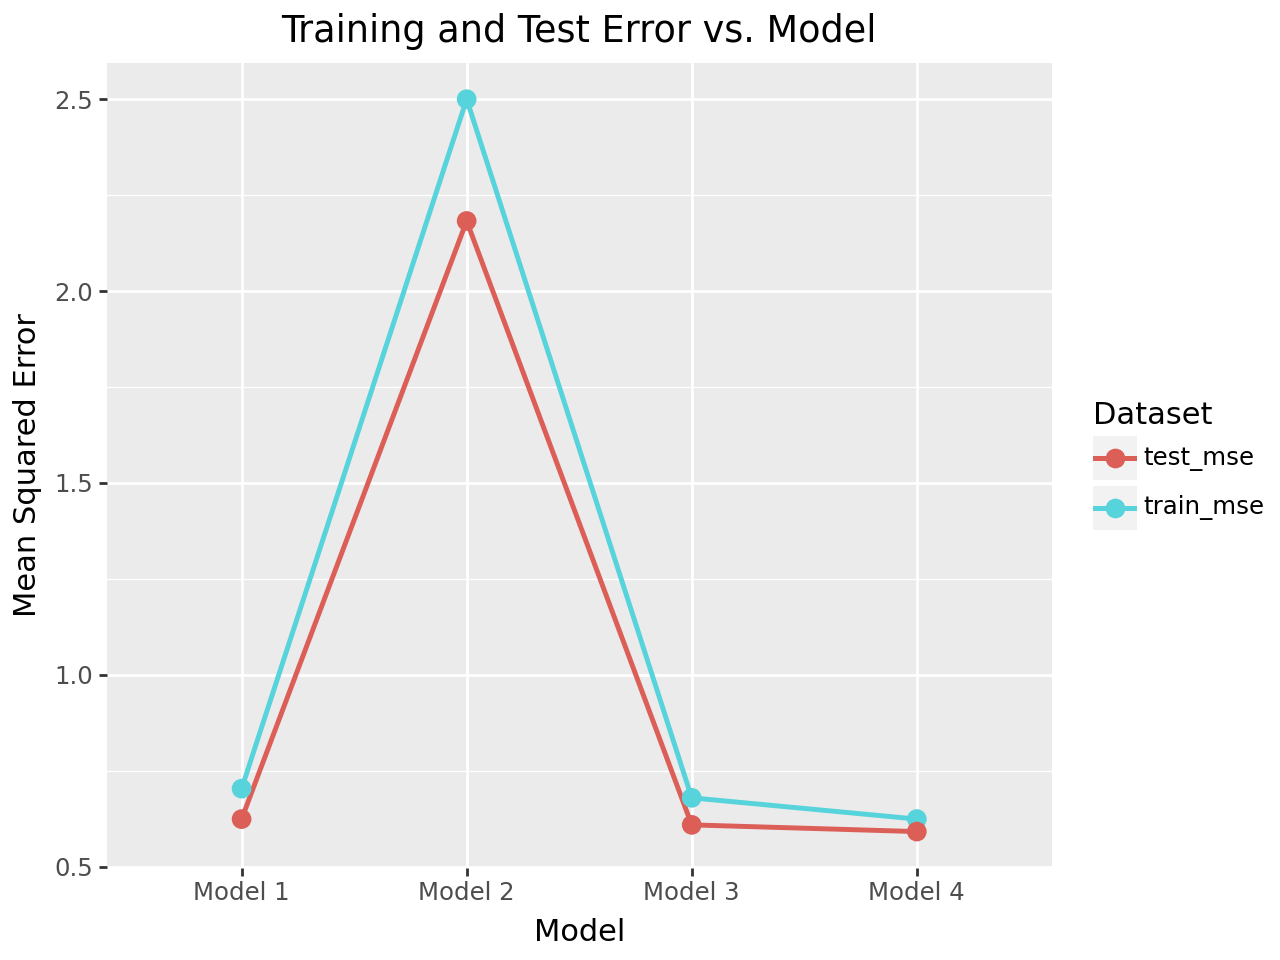

In [15]:
results_df = results_df.reset_index().rename(columns={'index': 'Model'})
results_melted = results_df.melt(id_vars='Model', var_name='Dataset', value_name='Mean Squared Error')

# Create the plot using plotnine
(ggplot(results_melted, aes(x='Model', y='Mean Squared Error', color='Dataset', group='Dataset')) +
    geom_line(size=1) +
    geom_point(size=3) +
    labs(title='Training and Test Error vs. Model', x='Model', y='Mean Squared Error')
)

The best model is Model 4 because it has the smallest MSE.